# Класифікація зображень  жестів на Keras-Tensorflow
### Структура ноутбуку:
 1)Завантаження зображень <br>
 2)Передобробка зображень<br>
 3)Створення конволюційної нейронної мережі (CNN)<br>
 4)Тренування та оцінка моделі<br>
 5) Застосування створеної моделі<br>


In [13]:
import tensorflow as tf
import cv2
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D


## Завантаження даних

In [14]:
import os

data = []

IMG_SIZE = (64,64)
data_dir = "data/" #директорія датасату
categories = [] #класи зображень (['dislike', 'ok', 'like', 'peace'])
for img in os.listdir(data_dir):
    category = img.split('.')[0]
    if category not in categories:
        categories.append(category)
    # завантаження зображеня та його трансформація
    img_path = os.path.join(data_dir,img)
    img_arr = cv2.imread(img_path,0) 
    img_arr = cv2.resize(img_arr, IMG_SIZE)
    img_arr = np.reshape(img_arr, (IMG_SIZE[0],IMG_SIZE[1],1))
    data.append([img_arr,categories.index(category)])
        
import random
random.shuffle(data)

In [15]:
print(categories)

['dislike', 'ok', 'like', 'peace']


## Розділення даних на тренувальні та тестові

In [16]:
print(len(data))
split = 0.7
train_data = data[0:int(len(data)*split)]
test_data = data[int(len(data)*split):-1]

402


## Форматування даних 

In [17]:
X_train = [] # вектор(одновимірний масив) зображень для тренування
y_train = [] # вектор лейблів для тренування (0,1,2 або 3) - цифра відповідає класу до якого належить зображення
for img,label in train_data:
    X_train.append(img)
    y_train.append(label)
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = [] # вектор зображень
y_test = [] # вектор лейблів
for img,label in test_data:
    X_test.append(img)
    y_test.append(label)
X_test = np.array(X_test)
y_test = np.array(y_test)


In [18]:
print(len(X_train))
print(len(X_test))

281
120


## Створення нейронної мережі

<img src="https://miro.medium.com/max/1896/1*qsbsCVyu376kqdnNcdxmmw.png">

In [19]:
print(X_train[0].shape) #розміри зображення, що подається на вхід

(64, 64, 1)


In [20]:
#Додати зображення архітектури
model = tf.keras.models.Sequential()
model.add(Conv2D(32,(3,3),input_shape=(64,64,1),activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2))) #if stride not given it equal to pool filter size
model.add(Conv2D(32,(3,3),activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Flatten())
model.add(Dense(units=128,activation='relu'))
model.add(Dense(units=len(categories),activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## Тренування Мережі

In [21]:
# Callback для припинення тренування, при умові досягнення точності 100%
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,log={}):
        if log.get('acc')==1.0:
            self.model.stop_training = True
            return

callback = myCallback()

In [24]:
#Код щоб збільшити ширину терміналу (запускати, якщо не видно всі логи в наступному блоці)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [25]:
model.fit(X_train, y_train, epochs=500, callbacks=[callback], validation_split=0.33) #validation split - відсоток тренувальних даних, що виділяються на валідацію.
                                                                                     #На цих даних перевіряєтья помилка і точність на кожній епосі.
                                                                                     #На валідаційних даних мережа не тренується

Train on 188 samples, validate on 93 samples
Epoch 1/500
188/188 [==============================] - 1s 4ms/sample - loss: 0.0068 - acc: 1.0000 - val_loss: 0.2082 - val_acc: 0.9355


<img src="https://miro.medium.com/proxy/1*Jcwx8HFKObTvolPYzx8rYw.png">

## Оцінення моделі на тестових даних та збереження моделі

In [13]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(test_loss, test_acc)

120/120 [==============================] - 0s 2ms/sample - loss: 0.0967 - acc: 0.9667
0.09665338086585204 0.96666664


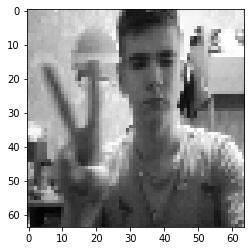

In [12]:
import matplotlib.pyplot as plt 
plt.imshow(X_test[3], cmap="gray")  

In [14]:
model.save('sign_reader.model') #Збереження Нейронної мережі

## Передбачення

In [15]:
signs_model = tf.keras.models.load_model('sign_reader.model') #завантажуємо нейронну мережу 

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [16]:
predictions = signs_model.predict(X_test)

peace


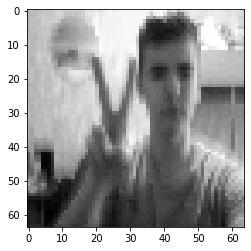

In [17]:
import matplotlib.pyplot as plt
plt.imshow(X_test[3], cmap="gray")


print(categories[np.argmax(predictions[3])])


ok


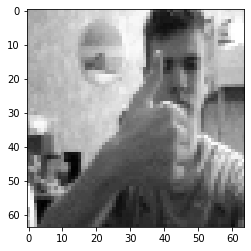

In [18]:
plt.imshow(X_test[7], cmap="gray")



print(categories[np.argmax(predictions[7])])


ok


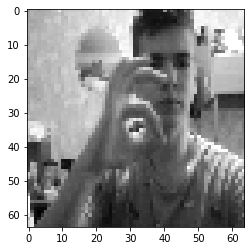

In [21]:
plt.imshow(X_test[11], cmap="gray")


print(categories[np.argmax(predictions[11])])


In [23]:
test_image = cv2.imread("./test_image.png")

In [24]:
def predict_on_image(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, IMG_SIZE)
    image = np.reshape(image, (IMG_SIZE[0],IMG_SIZE[1],1))
    img_to_pred = np.expand_dims(image, axis=0)
    prediction = signs_model.predict(img_to_pred)
    category_index = np.argmax(prediction)
    category = categories[category_index]
    return category

In [25]:
prediction = predict_on_image(test_image)
print(prediction)

dislike
